# Try to set up the simplest Solar + Storage model using SAM + SCC + PySAM

In [127]:
import os
import PySAM.Pvwattsv8 as pvwatts # https://nrel-pysam.readthedocs.io/en/main/modules/Pvwattsv8.html
import PySAM.Battery as battery_model # https://nrel-pysam.readthedocs.io/en/main/modules/Battery.html
import PySAM.ResourceTools as tools
import pandas as pd
import traceback

import PySAM
print(PySAM.__version__)

6.0.1


In [134]:
# import math

# def format_4sig(val):
#     """
#     Formats and prints a number or an iterable of numbers so that each number
#     is represented with 4 significant digits. For example:
#       - 73.9028  -> "73.90"
#       - 0.198608 -> "0.1986"
#       - 9.123456 -> "9.123"
#       - 12345    -> "1235"
    
#     The function prints the formatted result as a tuple-like string for iterables.
#     """
#     def format_number(x):
#         if x == 0:
#             return "0.000"
#         order = math.floor(math.log10(abs(x)))
#         decimals_needed = max(4 - (order + 1), 0)
#         format_str = "{:." + str(decimals_needed) + "f}"
#         return format_str.format(x)
    
#     # Check if val is iterable (but not a string)
#     try:
#         # We'll try iterating; if it's a string, we'll treat it as a single number.
#         if isinstance(val, (str, bytes)):
#             raise TypeError
#         iter(val)
#         # It's iterable: format each element.
#         formatted = ", ".join(format_number(x) for x in val)
#         return f"({formatted})"
#     except TypeError:
#         # Not iterable, treat as a single number.
#         return format_number(val)

import math

def format_4sig(val):
    """
    Formats a number or an iterable of numbers so that each number is
    represented with 4 significant digits (with trailing zeros where needed).
    Returns a tuple-like string if the input is iterable.
    
    Examples:
      - 73.9028  -> "73.90"
      - 0.198608 -> "0.1986"
      - 9.123456 -> "9.123"
      - 12345    -> "1235"
      - 1        -> "1.000"
      - 0.4852   -> "0.485"
    """
    def format_number(x):
        # Use general format for 4 significant digits.
        s = format(x, ".4g")
        # If scientific notation is used, leave it as is.
        if "e" in s or "E" in s:
            return s
        # If no decimal point is present, add one with trailing zeros.
        if "." not in s:
            s += ".000"
        else:
            # Count the number of significant digits already present in the integer part.
            # Remove any sign and leading zeros.
            intpart, fracpart = s.split(".")
            int_clean = intpart.lstrip("-0")
            sig_int = len(int_clean)
            # Calculate how many decimal places we need so that total significant digits = 4.
            decimals_needed = max(4 - sig_int, 0)
            s = f"{x:.{decimals_needed}f}"
        return s

    # If val is iterable (but not a string/bytes), format each element.
    try:
        if isinstance(val, (str, bytes)):
            raise TypeError
        iter(val)
        formatted = ", ".join(format_number(x) for x in val)
        return f"({formatted})"
    except TypeError:
        # If val is a single number, format it directly.
        return format_number(val)

# Example usage:
print(format_4sig(73.9028))   # Expected "73.90"
print(format_4sig(0.198608))  # Expected "0.1986"
print(format_4sig(9.123456))  # Expected "9.123"
print(format_4sig(12345))     # Expected "1235"
print(format_4sig(1))         # Expected "1.000"
print(format_4sig(0.4852))    # Expected "0.485"
print(format_4sig((1, 0.4852, 73.9028)))

73.90
0.1986
9.123
1.234e+04
1.000
0.4852
(1.000, 0.4852, 73.90)


In [ ]:
import PySAM.Pvwattsv8 as pvwatts # https://nrel-pysam.readthedocs.io/en/main/modules/Pvwattsv8.html
import PySAM.ResourceTools as tools
import numpy as np

# ---- Solar
weather_file = "/Users/ana/Documents/Berkeley/CCAI/cost-of-solar-storage/data/loadprofiles/baseline/single-family-detached/alameda/weather_TMY_alameda.csv"
solar_resource_data = tools.SAM_CSV_to_solar_data(weather_file)
solar = pvwatts.default("PVWattsResidential")
solar.SolarResource.solar_resource_file = weather_file
solar.execute(0)

analysis_period = 1
steps_in_year = 8760
days_in_year = 365

battery = battery_model.from_existing(solar, "CustomGenerationBatteryResidential")
# battery.SystemOutput.gen = gen # gen needs to be populated from solar, eg solar.SystemOutput.gen. If using .from_existing(solar, ...), this will be populated for you
# CustomGenerationBatteryResidential
# CustomGenerationBatterySingleOwner
# GenericBatteryResidential

load_profile = [10] * 8760
battery.Load.load = load_profile
battery.Lifetime.analysis_period = analysis_period

battery.BatteryCell.batt_initial_SOC = 100
battery.BatteryCell.batt_minimum_SOC = 0
battery.BatteryCell.batt_maximum_SOC = 100
battery.BatteryCell.batt_Qfull = 3 # Kwh

# battery.BatteryDispatch.batt_dispatch_auto_can_gridcharge = 0
# battery.BatteryDispatch.batt_dispatch_auto_can_curtailcharge = 0
# battery.BatteryDispatch.batt_dispatch_charge_only_system_exceeds_load = 0
# battery.BatteryDispatch.batt_dispatch_discharge_only_load_exceeds_system = 0
# 0=PeakShaving,1=InputGridTarget,2=InputBatteryPower,3=ManualDispatch,4=RetailRateDispatch,5=SelfConsumption 
# battery.BatteryDispatch.batt_dispatch_choice = 0

# Change from default dispatch to custom dispatch
# battery.BatteryDispatch.batt_dispatch_auto_can_charge = 1
battery.BatteryDispatch.batt_dispatch_choice = 0 # 0=PeakShaving,1=InputGridTarget,2=InputBatteryPower,3=ManualDispatch,4=RetailRateDispatch,5=SelfConsumption
battery.BatteryDispatch.batt_dispatch_charge_only_system_exceeds_load = 0
battery.BatteryDispatch.batt_dispatch_auto_can_charge = 1
battery.BatteryDispatch.batt_dispatch_auto_can_gridcharge = 1
# battery.BatteryDispatch.batt_custom_dispatch = lifetime_dispatch  # converts list to tuple

# battery.BatteryDispatch.batt_dispatch_auto_can_gridcharge = 1

try:
    battery.execute(0)
except Exception as e:
    print("An error occurred:")
    print(e)
    traceback.print_exc()

print(battery.BatterySystem.batt_meter_position)

print("")
print("----- Load -----")
print("load                            :", battery.Load.load[0:30])

print("----- Battery -----")
# print("dispatch_request                :", lifetime_dispatch[3:30])
# print("batt_power                      :", battery.Outputs.batt_power[0:30])
print("batt_SOC                        :", format_4sig(battery.Outputs.batt_SOC[0:30])) # [%]
print("batt_to_load                    :", format_4sig(battery.Outputs.batt_to_load[0:30])) # [kW] # This is the battery energy that is delivered to the household load on the AC side. In an AC-coupled system (the common residential configuration with PVWattsV8), this output is the main indicator of how much energy the battery is providing directly to your home’s load after the inverter losses are applied.
print("grid_to_batt                    :", format_4sig(battery.Outputs.grid_to_batt[0:30])) # [kW]
print("batt_to_grid                    :", format_4sig(battery.Outputs.batt_to_grid[0:30])) # [kW]
print("solar_to_batt                   :", format_4sig(battery.Outputs.system_to_batt_dc[0:30])) # [kW] # How much solar is charging the battery at a given time

# print("batt_to_system_load             :", battery.Outputs.batt_to_system_load[0:30]) # This value is used in some configurations to denote battery discharge that is applied “directly” to the system load, typically in scenarios where the battery might be coupled on the DC side or where the dispatch algorithm distinguishes between different pathways for battery energy. In many residential AC-coupled cases, this output remains zero because the battery’s contribution to the load is measured by batt_to_load.

print("----- Solar -----")
print("gen                             :", format_4sig(battery.SystemOutput.gen[0:30])) # [kW] # solar generation ?
print("solar_available:                :", format_4sig(battery.Outputs.gen_without_battery[0:48])) # [kW] # OK so this is just solar generation
print("system_to_load                  :", format_4sig(battery.Outputs.system_to_load[0:30])) # [kW]
print("system_to_grid                  :", format_4sig(battery.Outputs.system_to_grid[0:30]))

print("----- Grid -----")
print("grid_to_load                    :", format_4sig(battery.Outputs.grid_to_load[0:30]))


0.0

----- Load -----
load                            : (0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5)
----- Battery -----
batt_SOC                        : (100.000, 97.12, 94.24, 91.35, 88.45, 85.55, 82.63, 79.71, 76.79, 73.85, 70.90, 67.95, 64.98, 62.000, 59.01, 56.000, 62.70, 78.07, 84.99, 100.000, 100.000, 100.000, 100.000, 100.000, 100.000, 97.12, 94.25, 91.36, 88.46, 85.56)
batt_to_load                    : (0.000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000)
grid_to_batt                    : (0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000)
ba

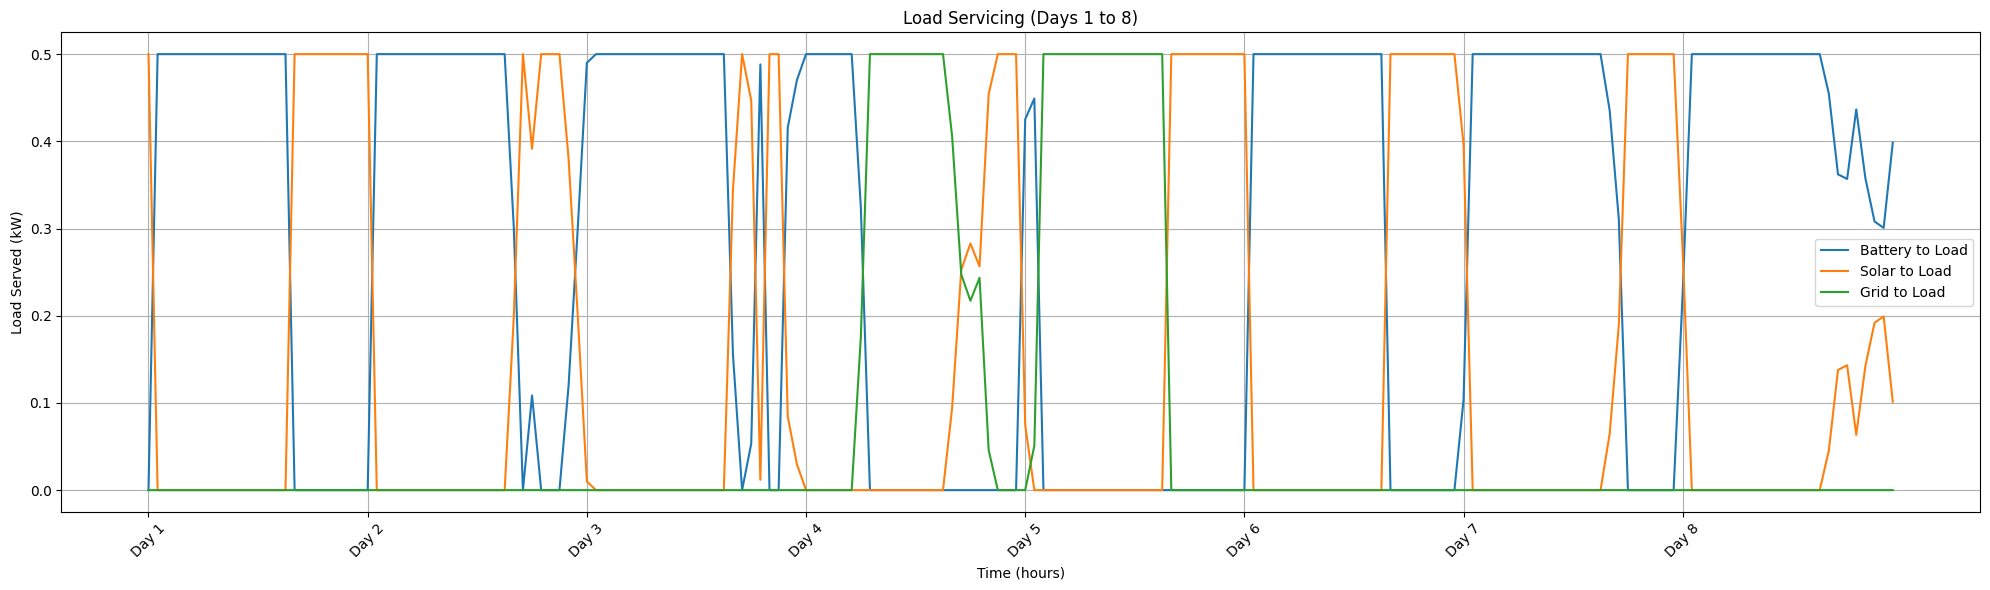

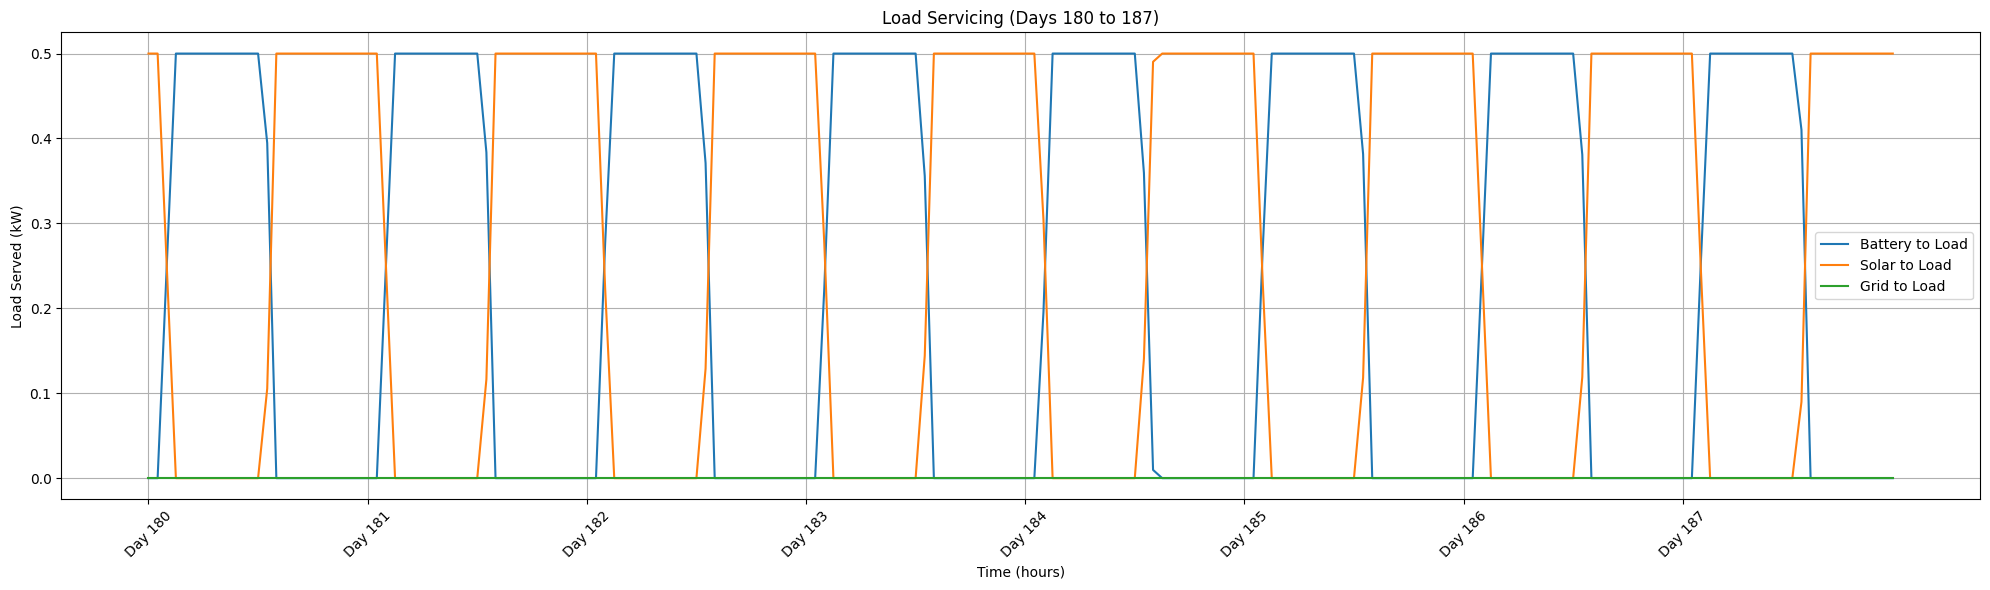

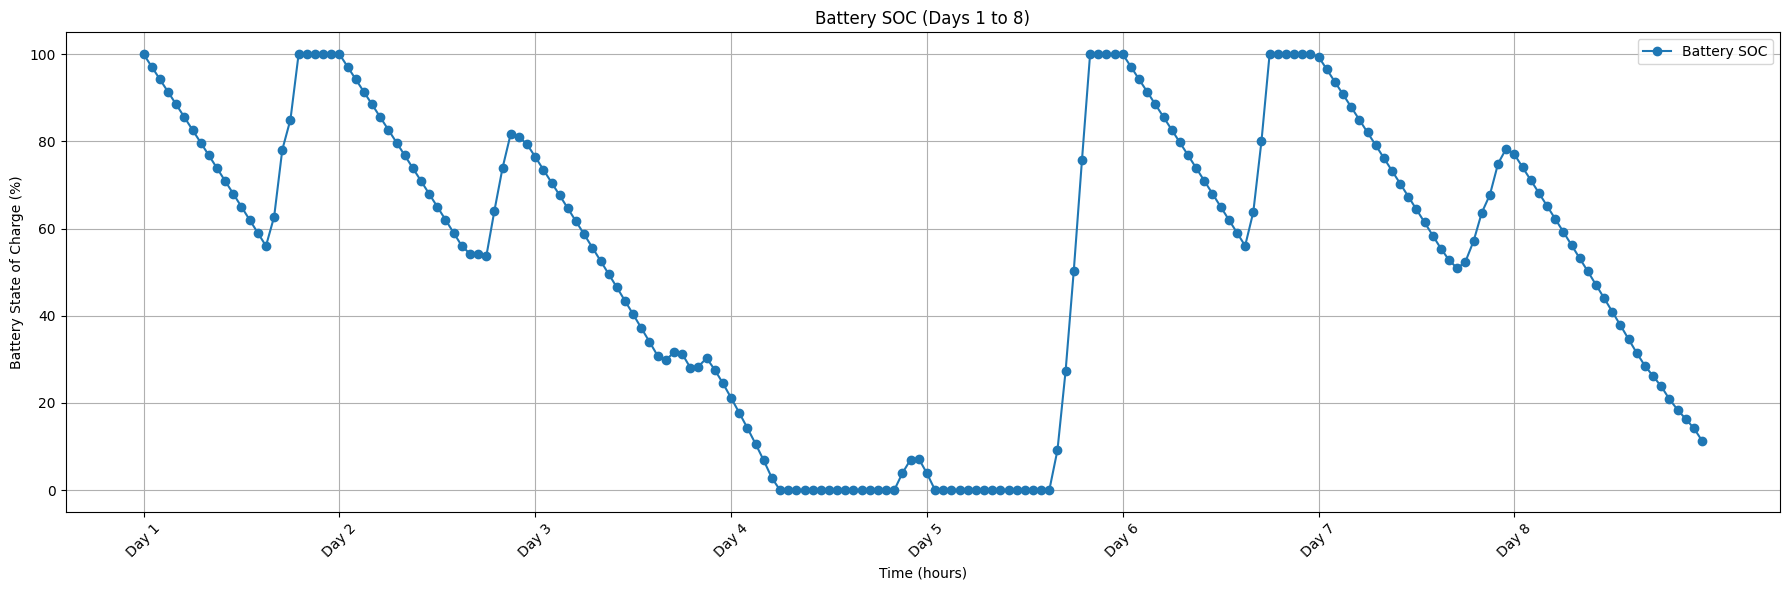

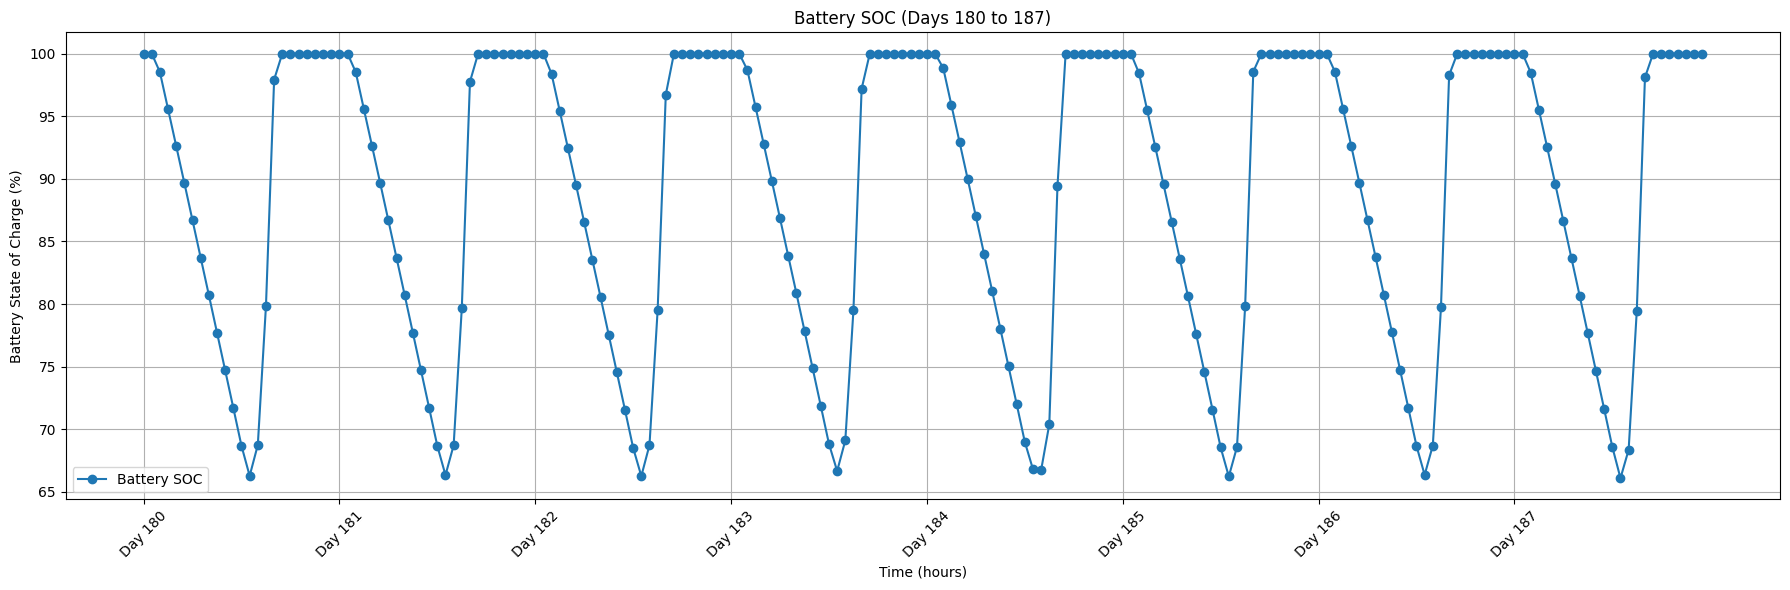

In [323]:
import matplotlib.pyplot as plt
import numpy as np

def set_day_ticks(ax, start_day, end_day, hours_per_day=24):
    # Create tick positions for each day boundary WITHOUT the extra tick
    tick_positions = np.arange((start_day - 1) * hours_per_day, end_day * hours_per_day, hours_per_day)
    tick_labels = [f"Day {i}" for i in range(start_day, end_day + 1)]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45)

def get_day_range_indices(start_day, end_day, hours_per_day=24):
    # Days are 1-indexed; end_day is inclusive
    start_idx = (start_day - 1) * hours_per_day
    end_idx = end_day * hours_per_day
    return start_idx, end_idx

# Get indices for week 1 (days 1 to 8) and week 2 (days 180 to 187)
week1_start, week1_end = get_day_range_indices(1, 8)
week2_start, week2_end = get_day_range_indices(180, 187)

hours_week1 = np.arange(week1_start, week1_end)
hours_week2 = np.arange(week2_start, week2_end)

# Extract data slices for week 1
batt_to_load_week1   = battery.Outputs.batt_to_load[week1_start:week1_end]
system_to_load_week1 = battery.Outputs.system_to_load[week1_start:week1_end]
grid_to_load_week1   = battery.Outputs.grid_to_load[week1_start:week1_end]
batt_SOC_week1       = battery.Outputs.batt_SOC[week1_start:week1_end]

# Extract data slices for week 2
batt_to_load_week2   = battery.Outputs.batt_to_load[week2_start:week2_end]
system_to_load_week2 = battery.Outputs.system_to_load[week2_start:week2_end]
grid_to_load_week2   = battery.Outputs.grid_to_load[week2_start:week2_end]
batt_SOC_week2       = battery.Outputs.batt_SOC[week2_start:week2_end]


# ---------------------------------
# Plot for Load Servicing Over Weeks
# ---------------------------------
# Week 1 Plot
plt.figure(figsize=(20, 6))
plt.plot(hours_week1, batt_to_load_week1, label="Battery to Load")
plt.plot(hours_week1, system_to_load_week1, label="Solar to Load")
plt.plot(hours_week1, grid_to_load_week1, label="Grid to Load")
plt.xlabel("Time (hours)")
plt.ylabel("Load Served (kW)")  # Adjust units as needed
plt.title("Load Servicing (Days 1 to 8)")
ax = plt.gca()
set_day_ticks(ax, 1, 8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Week 2 Plot
plt.figure(figsize=(20, 6))
plt.plot(hours_week2, batt_to_load_week2, label="Battery to Load")
plt.plot(hours_week2, system_to_load_week2, label="Solar to Load")
plt.plot(hours_week2, grid_to_load_week2, label="Grid to Load")
plt.xlabel("Time (hours)")
plt.ylabel("Load Served (kW)")
plt.title("Load Servicing (Days 180 to 187)")
ax = plt.gca()
set_day_ticks(ax, 180, 187)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------
# Plot for Battery SOC Over the Week
# ---------------------------------
# Week 1 SOC Plot
plt.figure(figsize=(18, 6))
plt.plot(hours_week1, batt_SOC_week1, marker="o", label="Battery SOC")
plt.xlabel("Time (hours)")
plt.ylabel("Battery State of Charge (%)")
plt.title("Battery SOC (Days 1 to 8)")
ax = plt.gca()
set_day_ticks(ax, 1, 8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Week 2 SOC Plot
plt.figure(figsize=(18, 6))
plt.plot(hours_week2, batt_SOC_week2, marker="o", label="Battery SOC")
plt.xlabel("Time (hours)")
plt.ylabel("Battery State of Charge (%)")
plt.title("Battery SOC (Days 180 to 187)")
ax = plt.gca()
set_day_ticks(ax, 180, 187)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

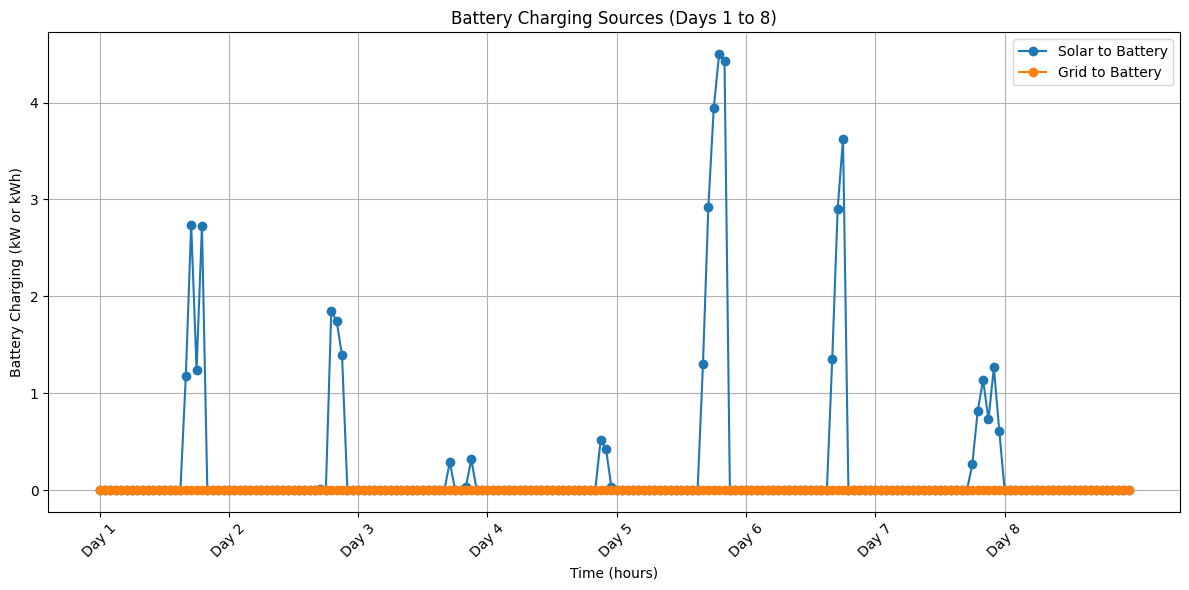

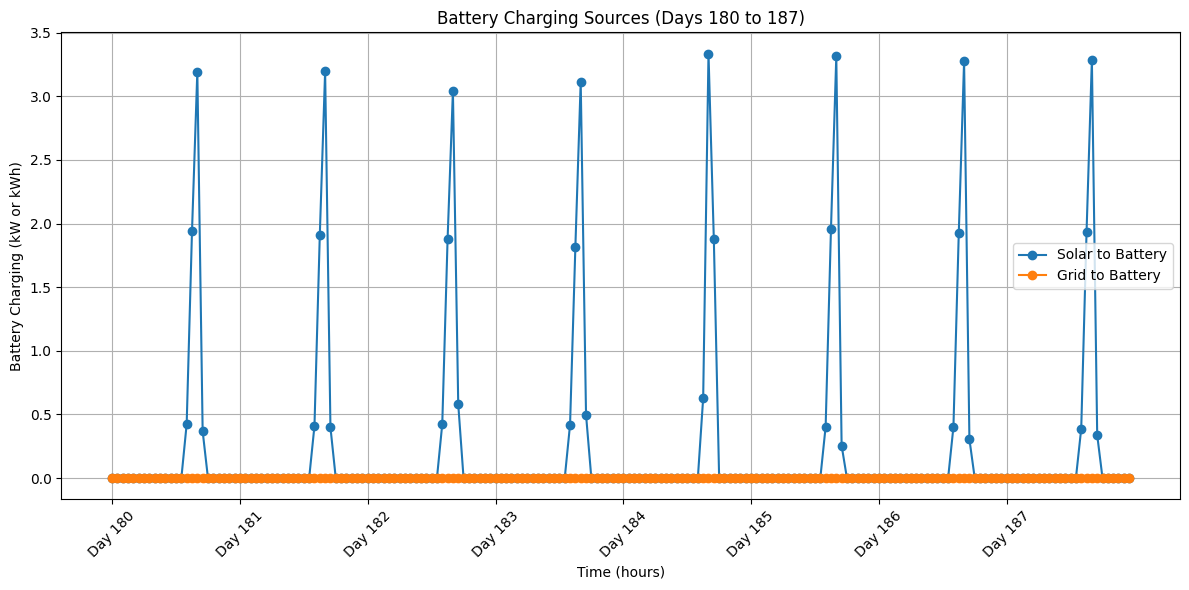

In [324]:
# -------------------------------
# How much does the battery get charged from solar vs. the grid?
# -------------------------------
solar_to_batt_week1 = np.array(battery.Outputs.system_to_batt_dc[week1_start:week1_end])
grid_to_batt_week1  = np.array(battery.Outputs.grid_to_batt[week1_start:week1_end])

solar_to_batt_week2 = np.array(battery.Outputs.system_to_batt_dc[week2_start:week2_end])
grid_to_batt_week2  = np.array(battery.Outputs.grid_to_batt[week2_start:week2_end])

# -------------------------------
# Plots
# -------------------------------

# Week 1: Overlaid line plots
plt.figure(figsize=(12, 6))
plt.plot(hours_week1, solar_to_batt_week1, marker='o', label="Solar to Battery")
plt.plot(hours_week1, grid_to_batt_week1, marker='o', label="Grid to Battery")
plt.xlabel("Time (hours)")
plt.ylabel("Battery Charging (kW or kWh)")
plt.title("Battery Charging Sources (Days 1 to 8)")
ax = plt.gca()
set_day_ticks(ax, 1, 8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Week 2: Overlaid line plots
plt.figure(figsize=(12, 6))
plt.plot(hours_week2, solar_to_batt_week2, marker='o', label="Solar to Battery")
plt.plot(hours_week2, grid_to_batt_week2, marker='o', label="Grid to Battery")
plt.xlabel("Time (hours)")
plt.ylabel("Battery Charging (kW or kWh)")
plt.title("Battery Charging Sources (Days 180 to 187)")
ax = plt.gca()
set_day_ticks(ax, 180, 187)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

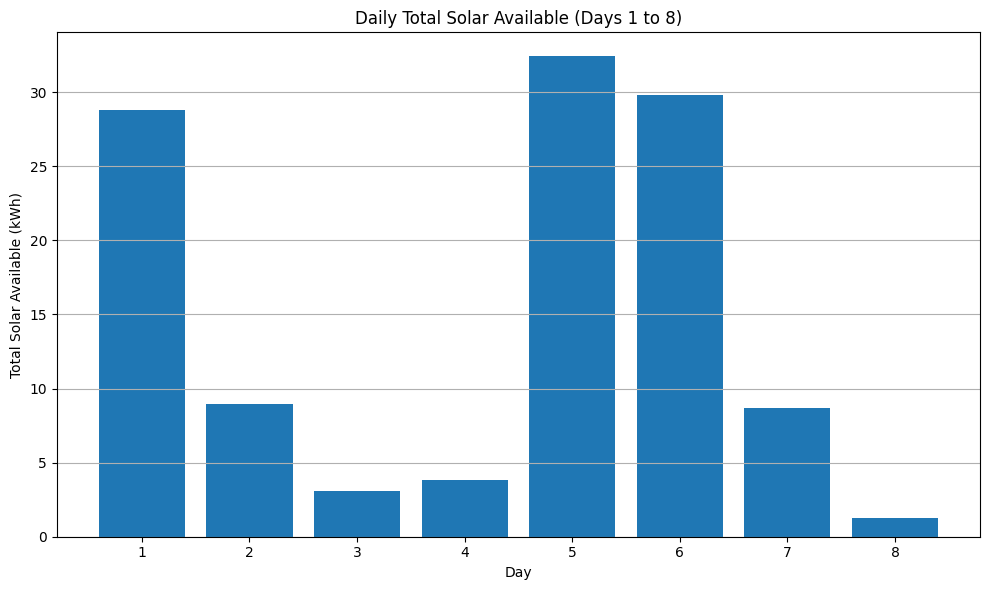

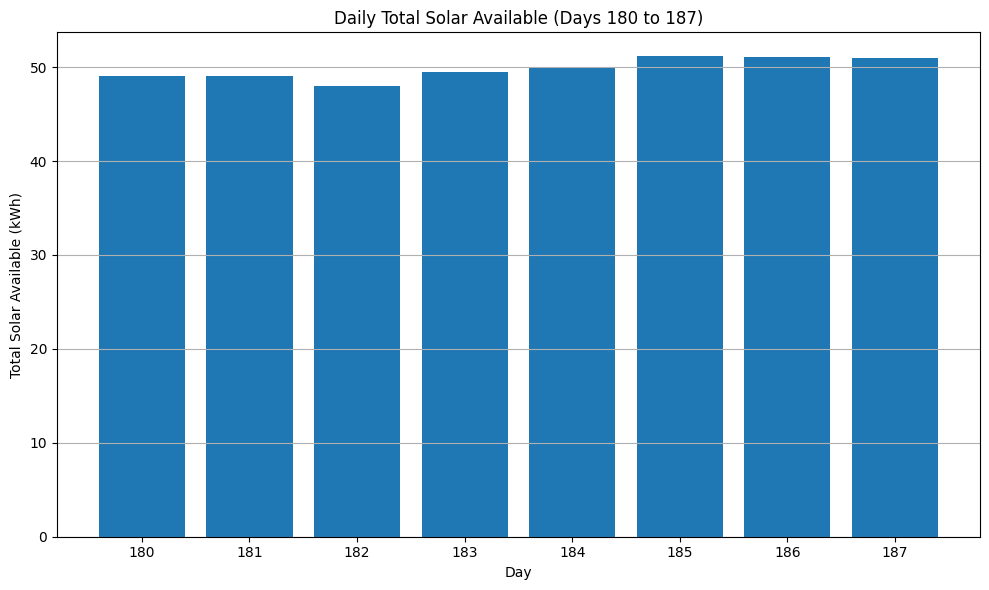

In [325]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to get indices for a block of days
def get_day_range_indices(start_day, end_day, hours_per_day=24):
    # Days are 1-indexed; end_day is inclusive.
    start_idx = (start_day - 1) * hours_per_day
    end_idx = end_day * hours_per_day
    return start_idx, end_idx

# Get indices for week 1 (days 1 to 8) and week 2 (days 180 to 187)
week1_start, week1_end = get_day_range_indices(1, 8)
week2_start, week2_end = get_day_range_indices(180, 187)

# Extract solar available hourly data for each week.
# (Assumes battery.Outputs.gen_without_battery holds the solar available values.)
solar_available_week1 = np.array(battery.Outputs.gen_without_battery[week1_start:week1_end])
solar_available_week2 = np.array(battery.Outputs.gen_without_battery[week2_start:week2_end])

# Reshape the hourly data into daily blocks (each day has 24 hours) and compute daily totals.
# For week 1 (8 days)
daily_totals_week1 = solar_available_week1.reshape(-1, 24).sum(axis=1)
# For week 2 (8 days)
daily_totals_week2 = solar_available_week2.reshape(-1, 24).sum(axis=1)

# Create day labels (days are 1-indexed for week 1, and actual day numbers for week 2)
days_week1 = np.arange(1, 9)       # Days 1 to 8
days_week2 = np.arange(180, 188)   # Days 180 to 187

# -----------------------------
# Plot for Daily Total Solar Available
# -----------------------------
# Week 1 Plot: Days 1 to 8
plt.figure(figsize=(10, 6))
plt.bar(days_week1, daily_totals_week1)
plt.xlabel("Day")
plt.ylabel("Total Solar Available (kWh)")  # Adjust units as needed
plt.title("Daily Total Solar Available (Days 1 to 8)")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# Week 2 Plot: Days 180 to 187
plt.figure(figsize=(10, 6))
plt.bar(days_week2, daily_totals_week2)
plt.xlabel("Day")
plt.ylabel("Total Solar Available (kWh)")
plt.title("Daily Total Solar Available (Days 180 to 187)")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# Start with just storage
https://nrel-pysam.readthedocs.io/en/latest/modules/Battery.html

In [326]:
battery.Outputs.export().keys()

dict_keys(['annual_export_to_grid_energy', 'annual_import_to_grid_energy', 'average_battery_conversion_efficiency', 'average_battery_roundtrip_efficiency', 'batt_DOD', 'batt_DOD_cycle_average', 'batt_I', 'batt_SOC', 'batt_annual_charge_energy', 'batt_annual_charge_from_grid', 'batt_annual_charge_from_system', 'batt_annual_discharge_energy', 'batt_annual_energy_loss', 'batt_annual_energy_system_loss', 'batt_availability_loss', 'batt_bank_installed_capacity', 'batt_bank_replacement', 'batt_capacity_percent', 'batt_capacity_percent_calendar', 'batt_capacity_percent_cycle', 'batt_capacity_thermal_percent', 'batt_conversion_loss', 'batt_cycles', 'batt_grid_charge_percent', 'batt_power', 'batt_power_dc', 'batt_power_target', 'batt_q0', 'batt_qmax', 'batt_qmax_thermal', 'batt_system_charge_percent', 'batt_system_loss', 'batt_temperature', 'batt_to_grid', 'batt_to_inverter_dc', 'batt_to_load', 'batt_to_system_load', 'batt_voltage', 'batt_voltage_cell', 'batt_year1_charge_from_grid', 'batt_year

annual_export_to_grid_energy
annual_import_to_grid_energy
average_battery_conversion_efficiency
average_battery_roundtrip_efficiency
batt_DOD
batt_DOD_cycle_average
batt_I
batt_SOC
batt_annual_charge_energy
batt_annual_charge_from_grid
batt_annual_charge_from_system
batt_annual_discharge_energy
batt_annual_energy_loss
batt_annual_energy_system_loss
batt_availability_loss
batt_bank_installed_capacity
batt_bank_replacement
batt_capacity_percent
batt_capacity_percent_calendar
batt_capacity_percent_cycle
batt_capacity_thermal_percent
batt_conversion_loss
batt_cycles
batt_grid_charge_percent
batt_power
batt_power_dc
batt_q0
batt_qmax
batt_qmax_thermal
batt_system_charge_percent
batt_system_loss
batt_temperature
batt_to_grid
batt_to_inverter_dc
batt_to_load
batt_to_system_load
batt_voltage
batt_voltage_cell
batt_year1_charge_from_grid
batt_year1_charge_from_system
capacity_factor_sales
crit_load
gen_without_battery
grid_power
grid_to_batt
grid_to_load
interconnection_loss
monthly_batt_to_grid
monthly_batt_to_load
monthly_grid_to_batt
monthly_grid_to_load
monthly_interconnection_loss
monthly_system_to_batt
monthly_system_to_grid
monthly_system_to_load
system_to_batt
system_to_batt_dc
system_to_grid
system_to_load

In [327]:
def print_module_defaults(module_obj):
    # Use dir() to list attribute names and filter out those starting with an underscore
    attributes = [attr for attr in dir(module_obj) if not attr.startswith('_')]
    
    for attr in attributes:
        try:
            # Get the attribute's value
            value = getattr(module_obj, attr)
            # Filter out callables (methods/functions)
            # Callable items are methods that represent operations or actions rather than stored data 
            # I'm just interested in the stored data, aka the "defaults" that come with a particular preset
            if not callable(value):
                print(f"  {attr}: {value}")
        except Exception as e:
            print(f"  {attr}: Error accessing attribute ({e})")
            
# List of module names to iterate through
modules = [
    "Simulation", "Lifetime", "BatterySystem", "SystemOutput", "Load",
    "BatteryCell", "Inverter", "Losses", "BatteryDispatch", "SystemCosts",
    "FuelCell", "PriceSignal", "Revenue", "ElectricityRates", "GridLimits"
]

# Loop through each module in the battery object, print keys and default values
for module_name in modules:
    module_obj = getattr(battery, module_name, None)
    if module_obj is None:
        print(f"Module '{module_name}' not found on battery object.")
    else:
        print(f"Module: {module_name}")
        print_module_defaults(module_obj)
    print("-" * 40)

Module: Simulation
  percent_complete: 199.79452514648438
  timestep_minutes: Error accessing attribute (Runtime error: get_timestep_minutes called for SAM_Battery but "timestep_minutes" not assigned
)
----------------------------------------
Module: Lifetime
  analysis_period: 1.0
  inflation_rate: 2.5
  system_use_lifetime_output: 1.0
----------------------------------------
Module: BatterySystem
  batt_ac_dc_efficiency: 96.0
  batt_ac_or_dc: 1.0
  batt_computed_bank_capacity: 12.474
  batt_computed_series: 14.0
  batt_computed_strings: 110.0
  batt_current_charge_max: 99.0
  batt_current_choice: 1.0
  batt_current_discharge_max: 99.0
  batt_dc_ac_efficiency: 96.0
  batt_dc_dc_efficiency: 99.0
  batt_inverter_efficiency_cutoff: 90.0
  batt_loss_choice: 0.0
  batt_losses: (0.0,)
  batt_losses_charging: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
  batt_losses_discharging: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
  batt_losses_idle: (0.0, 0.0, 0.0, 

# Add solar